# Imports and preprocessing

In [1]:
import pickle

import matplotlib.pyplot as plt
import os
import numpy as np
from plotting_functions.plotting_structure import combine_experiments
from plotting_functions.utils_plotting import save_figure
from plotting_functions.boxplots import boxplot, boxplot_larval_stage, violinplot
from plotting_functions.proportions import (
    plot_correlation,
    plot_continuous_deviation_from_model,
    plot_correlation_at_ecdysis,
    plot_normalized_proportions_at_ecdysis,
    plot_model_comparison_at_ecdysis,
    plot_deviation_from_model_at_ecdysis,
    plot_deviation_from_model_development_percentage,
    compute_deviation_from_model_at_ecdysis,
    compute_deviation_from_model_development_percentage,
)

from plotting_functions.utils_data_processing import (
    transform_series,
    compute_growth_rate,
    rescale,
    rescale_without_flattening,
    combine_series,
    smooth_series,
    smooth_and_rescale_series,
    detrend_rescaled_series_population_mean,
)

from plotting_functions.heterogeneity import (
    plot_cv_at_ecdysis,
    plot_std_at_ecdysis,
    plot_cv_development_percentage,
    plot_cv_rescaled_data,
)

from plotting_functions.curves import (
    plot_aggregated_series,
)

import warnings
import bottleneck as bn

# Configure warnings
warnings.filterwarnings("once")

In [2]:
filemap_paths = [
    "/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/report/analysis_filemap_annotated.csv",
    "/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/report/analysis_filemap_annotated.csv",
]

conditions_paths = [
    "/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/doc/conditions.yaml",
    "/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/doc/conditions.yaml",
]

organ_channels = [{'body': 'ch2', 'pharynx' : 'ch1'}]
# 

backup_path = "/path/to/backup/directory"
backup = False

In [3]:
conditions_struct = combine_experiments(filemap_paths, conditions_paths, organ_channels=organ_channels, recompute_values_at_molt=False)

Could not concatenate description: zero-dimensional arrays cannot be concatenated
Could not concatenate condition_id: zero-dimensional arrays cannot be concatenated
Could not concatenate description: zero-dimensional arrays cannot be concatenated
Could not concatenate condition_id: zero-dimensional arrays cannot be concatenated
Could not concatenate description: zero-dimensional arrays cannot be concatenated
Could not concatenate condition_id: zero-dimensional arrays cannot be concatenated
Could not concatenate description: zero-dimensional arrays cannot be concatenated
Could not concatenate condition_id: zero-dimensional arrays cannot be concatenated
Could not concatenate description: zero-dimensional arrays cannot be concatenated
Could not concatenate condition_id: zero-dimensional arrays cannot be concatenated
Could not concatenate description: zero-dimensional arrays cannot be concatenated
Could not concatenate condition_id: zero-dimensional arrays cannot be concatenated


In [4]:
structure_backup_path = os.path.join(backup_path, "structure")

# backup the conditions struct
if backup:
    os.makedirs(backup_path, exist_ok=True)
    os.makedirs(structure_backup_path, exist_ok=True)
    with open(os.path.join(backup_path, "conditions_struct.pkl"), "wb") as f:
        pickle.dump(conditions_struct, f)

In [5]:
for condition in conditions_struct:
    print(f"Condition: {condition['condition_id'], {condition['description']}}, Number of individuals: {condition['ecdysis_time_step'].shape[0]}")

Condition: (0, {'no TIR, raga-1:AID, 500uM IAA'}), Number of individuals: 58
Condition: (1, {'col-10:TIR, raga-1:AID, 500uM IAA'}), Number of individuals: 55
Condition: (2, {'yap-1 (tm1416), no TIR, raga-1:AID, 500uM IAA'}), Number of individuals: 79
Condition: (3, {'yap-1 (tm1416), col-10:TIR, raga-1:AID, 500uM IAA'}), Number of individuals: 76
Condition: (4, {'yap-1 (abt7), no TIR, raga-1:AID, 500uM IAA'}), Number of individuals: 99
Condition: (5, {'yap-1 (abt7), col-10:TIR, raga-1:AID, 500uM IAA'}), Number of individuals: 155


In [6]:
# change figure size to your liking
plt.rcParams['figure.figsize'] = [12, 10]

# make lines thicker
plt.rcParams['lines.linewidth'] = 2

# make font size bigger
plt.rcParams.update({'font.size': 12})

In [7]:
# define colors for each condition
colors = {
    0: '#02d3f4', # light blue
    1: '#045561', # dark blue
    2: '#70f221', # light green
    3: '#316411', # dark green
    4: '#ff2727', # light red
    5: '#a91d1d', # dark red
}

In [8]:
# rescale some series for plotting later
rescale_n_points = 100

conditions_struct = rescale(conditions_struct, 'body_seg_str_volume', 'body_seg_str_volume_rescaled', n_points=rescale_n_points)
conditions_struct = rescale(conditions_struct, 'body_seg_str_length', 'body_seg_str_length_rescaled', n_points=rescale_n_points)
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_volume', 'pharynx_seg_str_volume_rescaled', n_points=rescale_n_points)
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_length', 'pharynx_seg_str_length_rescaled', n_points=rescale_n_points)

# yap-1 mutant's growth gets slowed down more under col-10:TIR raga-1:AID

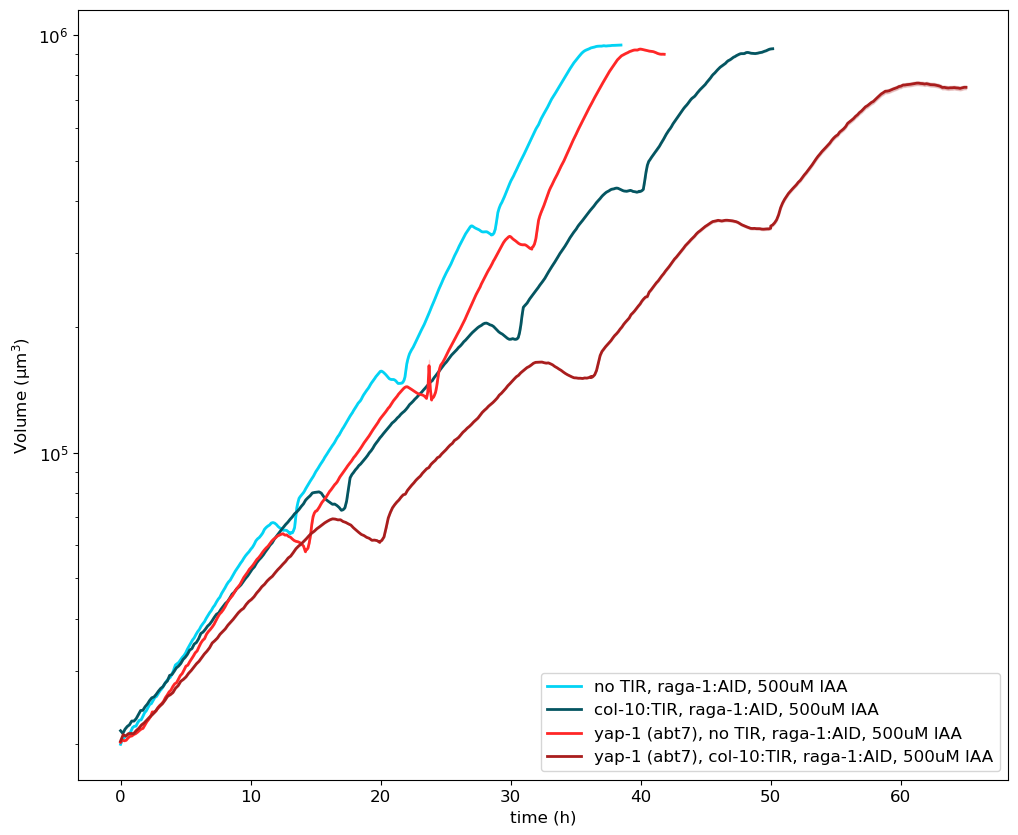

In [9]:
conditions_to_plot = [0, 1, 4, 5]

fig = plot_aggregated_series(
    conditions_struct,
    ["body_seg_str_volume"],
    conditions_to_plot,
    experiment_time=True,
    aggregation="mean",
    n_points=100,
    time_step=10,
    log_scale=True,
    colors=colors,
    legend={"description": ""},
    y_axis_label=r"Volume $(\mathrm{\mu m^3})$",
)

/home/spsalmon/micromamba/envs/towbintools/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical

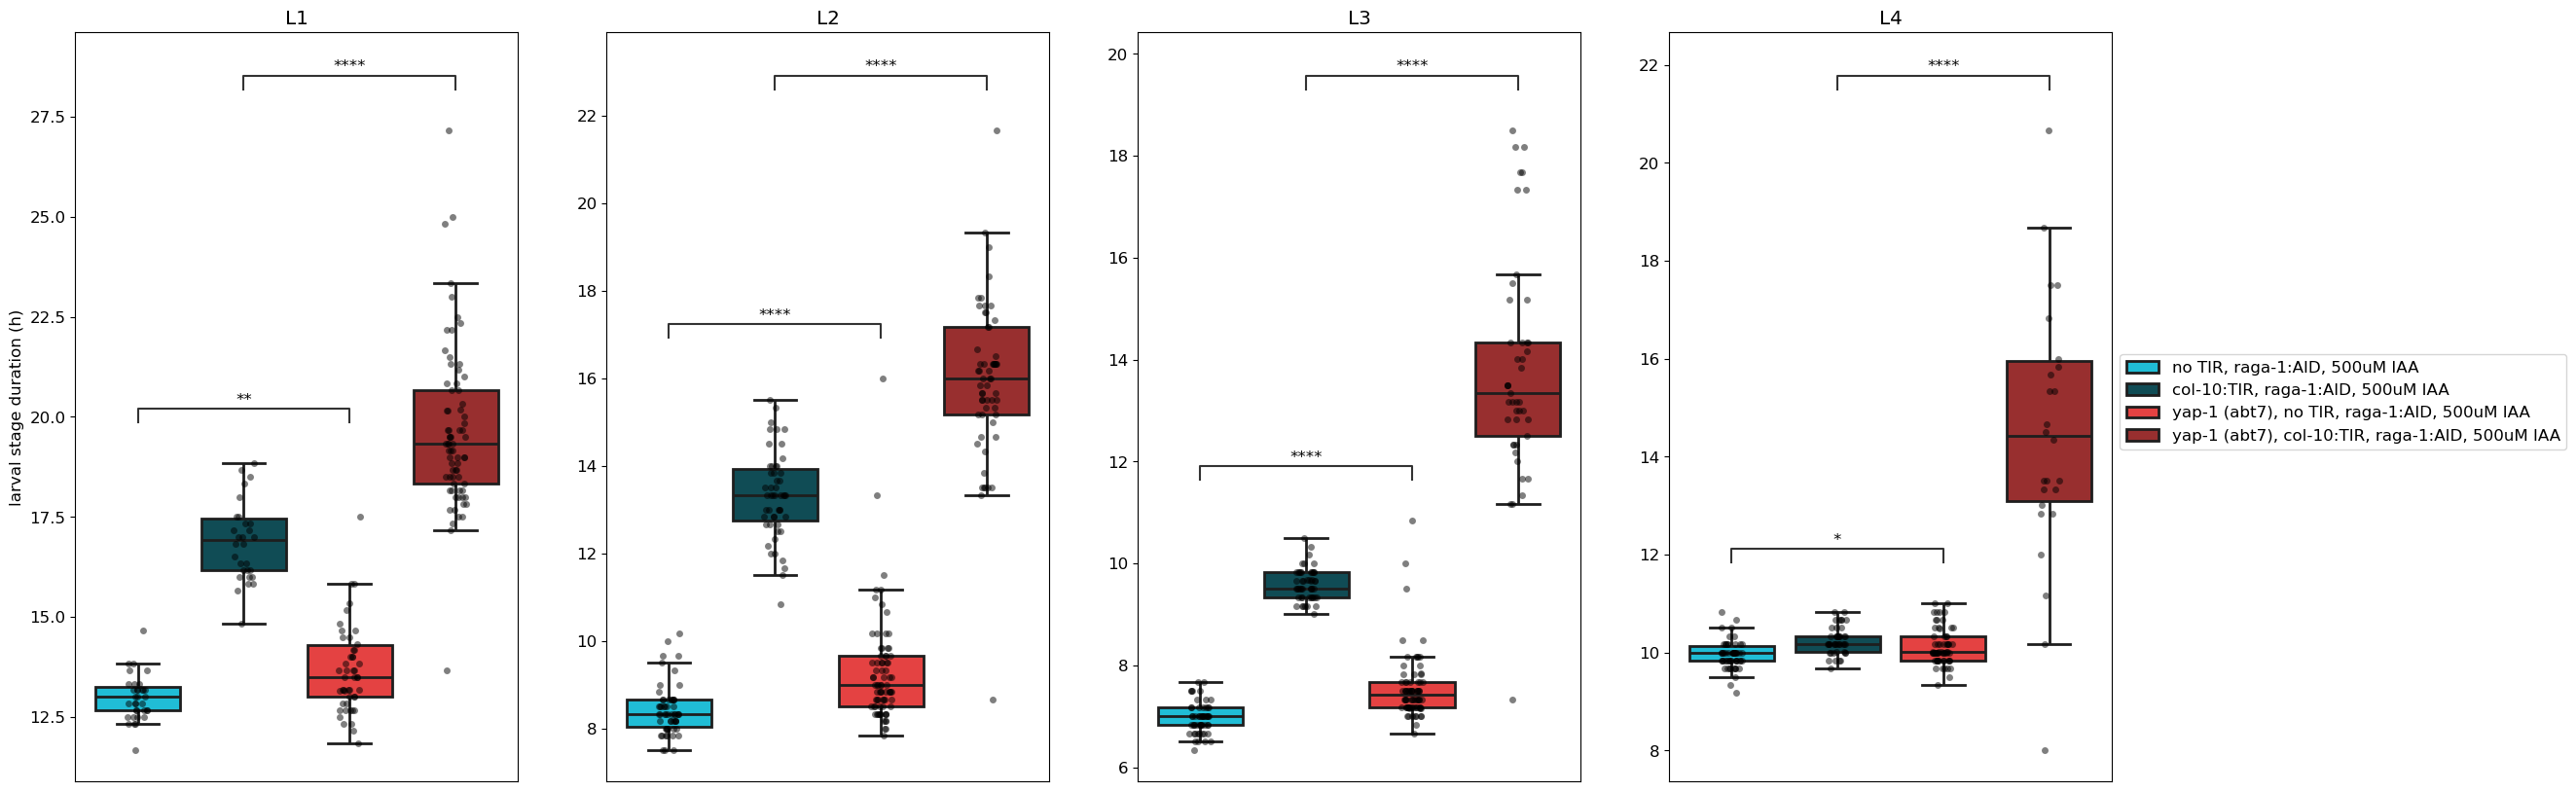

In [10]:
conditions_to_plot = [0, 1, 4, 5]
significance_pairs = [(0, 4), (1, 5)]
fig = boxplot(
    conditions_struct,
    "larval_stage_durations_experiment_time_hours",
    conditions_to_plot,
    colors=colors,
    share_y_axis=False,
    plot_significance=True,
    significance_pairs=significance_pairs,
    log_scale=False,
    legend={"description": ""},
    y_axis_label="larval stage duration (h)",
    titles=["L1", "L2", "L3", "L4"],
)

/home/spsalmon/micromamba/envs/towbintools/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical

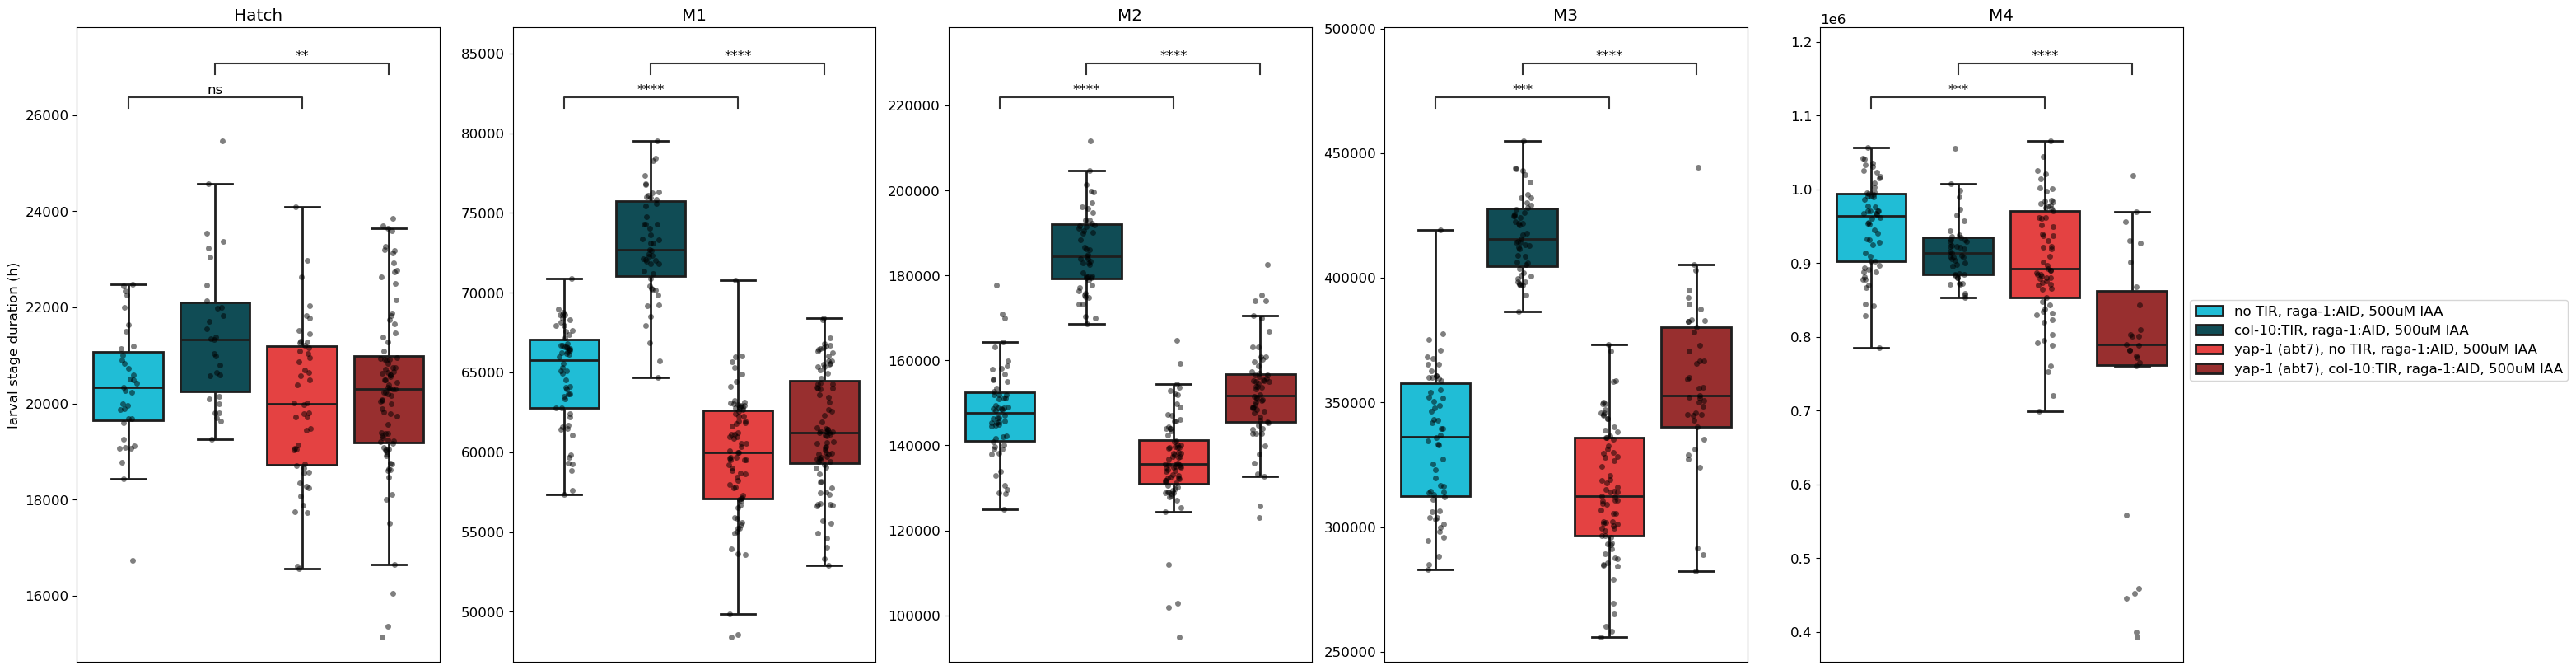

In [11]:
conditions_to_plot = [0, 1, 4, 5]
significance_pairs = [(0, 4), (1, 5)]
fig = boxplot(
    conditions_struct,
    "body_seg_str_volume_at_ecdysis",
    conditions_to_plot,
    colors=colors,
    share_y_axis=False,
    plot_significance=True,
    significance_pairs=significance_pairs,
    log_scale=False,
    legend={"description": ""},
    y_axis_label="larval stage duration (h)",
    titles=["Hatch", "M1", "M2", "M3", "M4"],
)

# yap-1 mutation causes dumpiness, amplified by epidermal growth inhibition

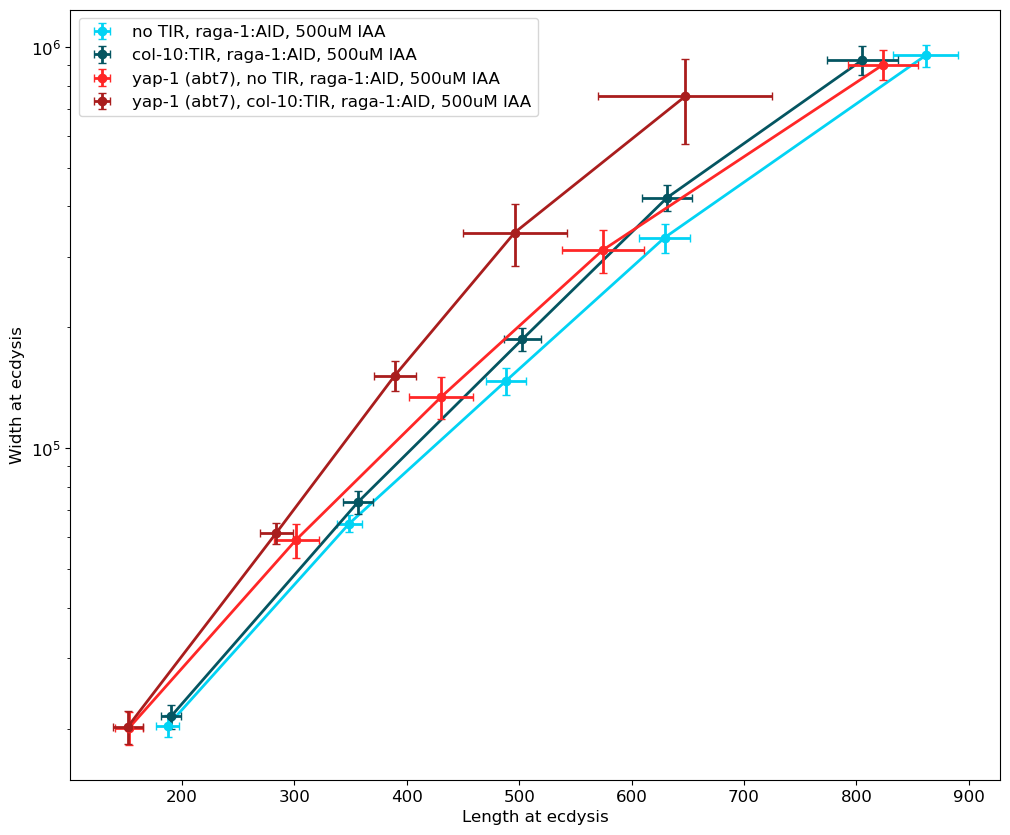

In [12]:
fig = plot_correlation_at_ecdysis(
    conditions_struct,
    "body_seg_str_length_at_ecdysis",
    "body_seg_str_volume_at_ecdysis",
    conditions_to_plot,
    remove_hatch=False,
    colors=colors,
    log_scale=(False, True),
    legend={"description": ""},
    y_axis_label="Width at ecdysis",
    x_axis_label="Length at ecdysis",
)

# yap-1 mutation causes pharynx dumpiness, amplified by epidermal growth inhibition

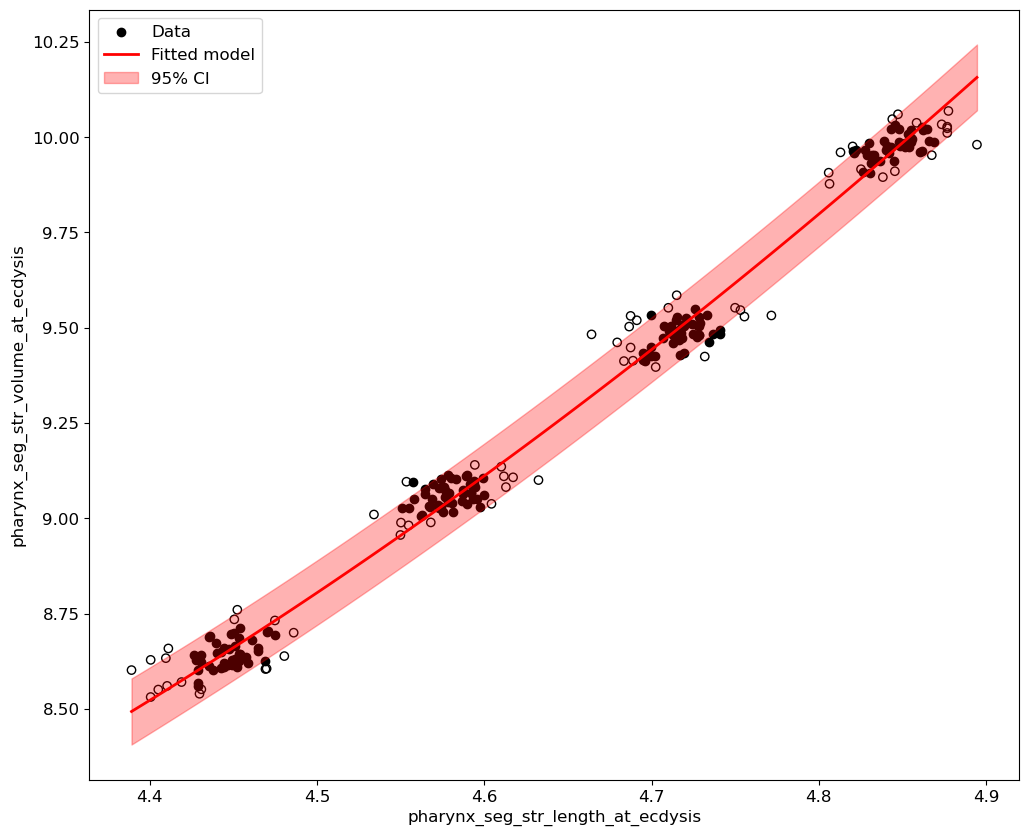

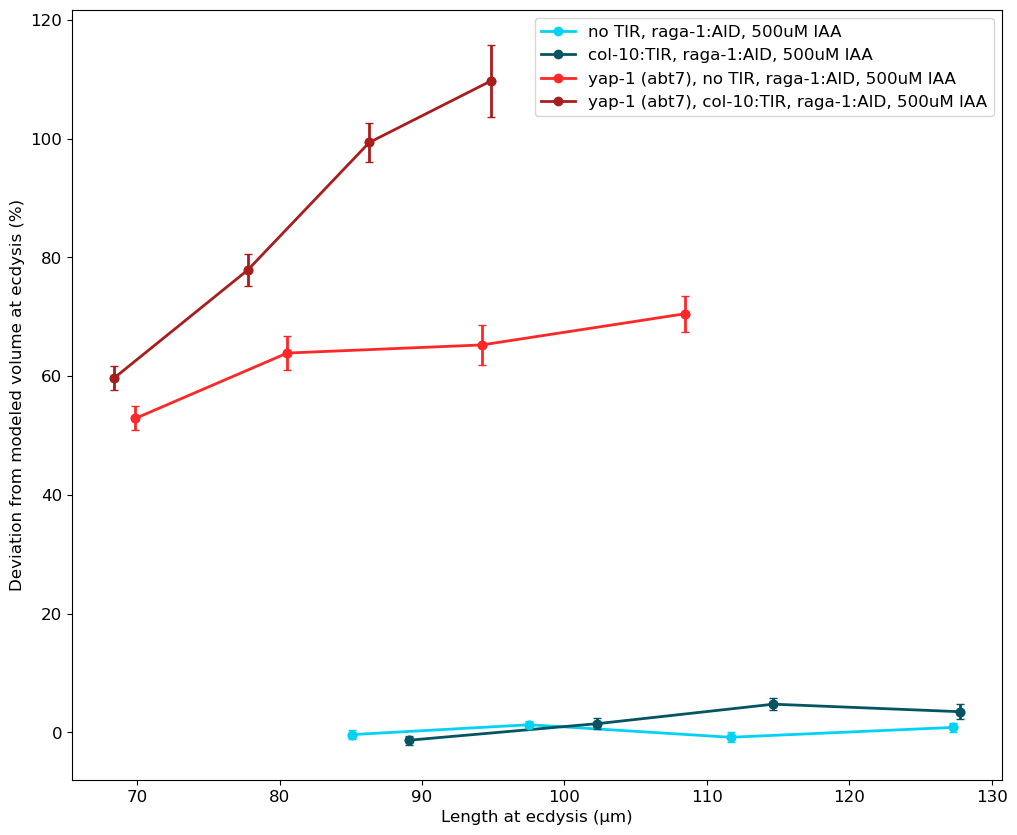

In [13]:
control_condition = 0
fig = plot_deviation_from_model_at_ecdysis(
    conditions_struct,
    "pharynx_seg_str_length_at_ecdysis",
    "pharynx_seg_str_volume_at_ecdysis",
    control_condition,
    conditions_to_plot,
    colors=colors,
    remove_hatch=True,
    log_scale=False,
    legend={"description": ""},
    x_axis_label="Length at ecdysis (µm)",
    y_axis_label="Deviation from modeled volume at ecdysis (%)",
    poly_degree=2,
)

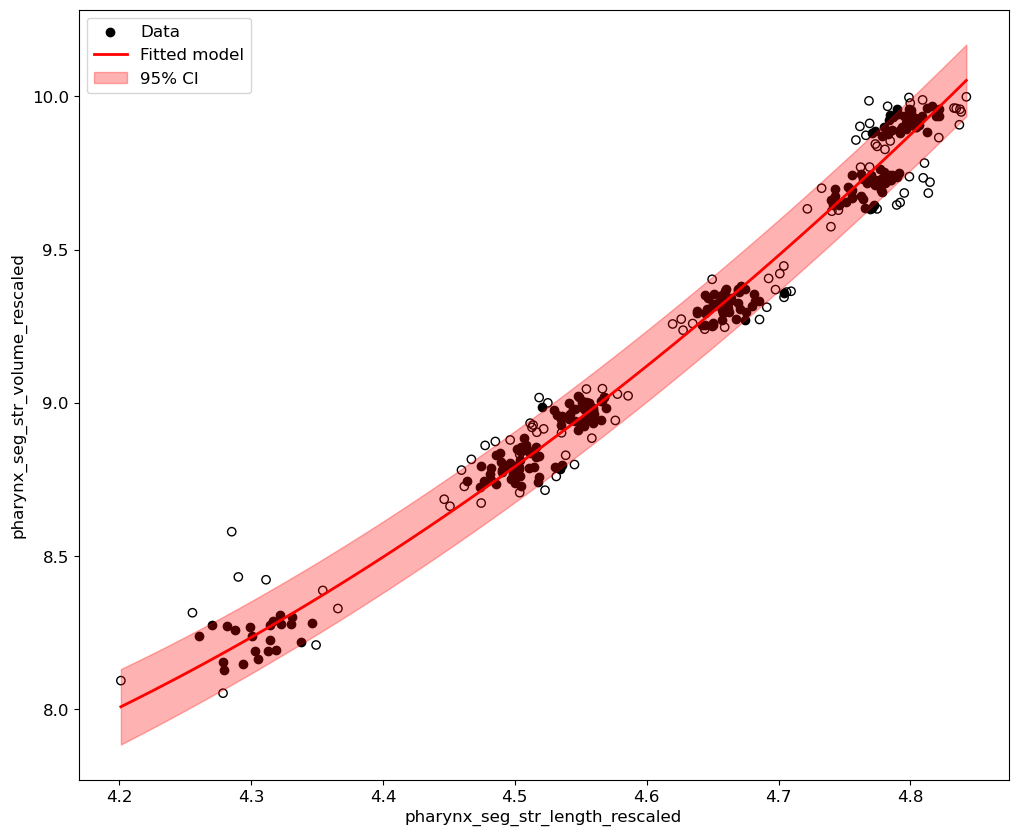

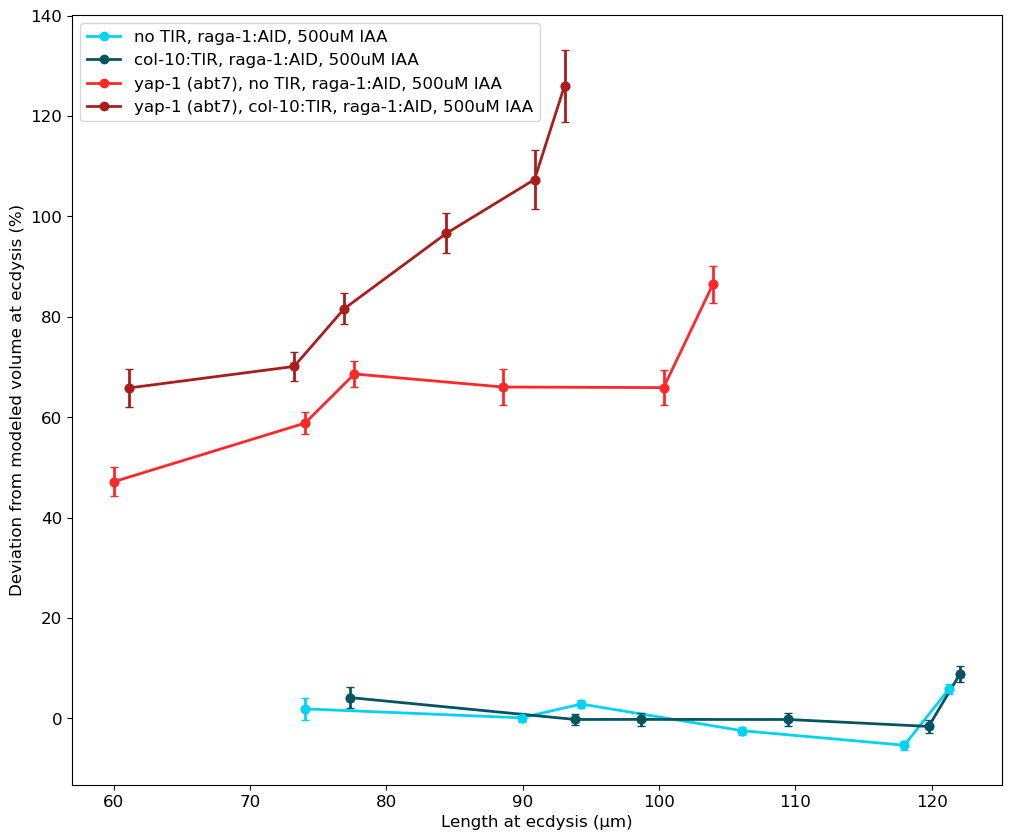

In [20]:
fig = plot_deviation_from_model_development_percentage(
    conditions_struct,
    "pharynx_seg_str_length_rescaled",
    "pharynx_seg_str_volume_rescaled",
    control_condition,
    conditions_to_plot,
    percentages=np.array([0.1, 0.3, 0.4, 0.6, 0.8, 0.9]),
    colors=colors,
    log_scale=False,
    legend={"description": ""},
    x_axis_label="Length at ecdysis (µm)",
    y_axis_label="Deviation from modeled volume at ecdysis (%)",
    poly_degree=2,
)

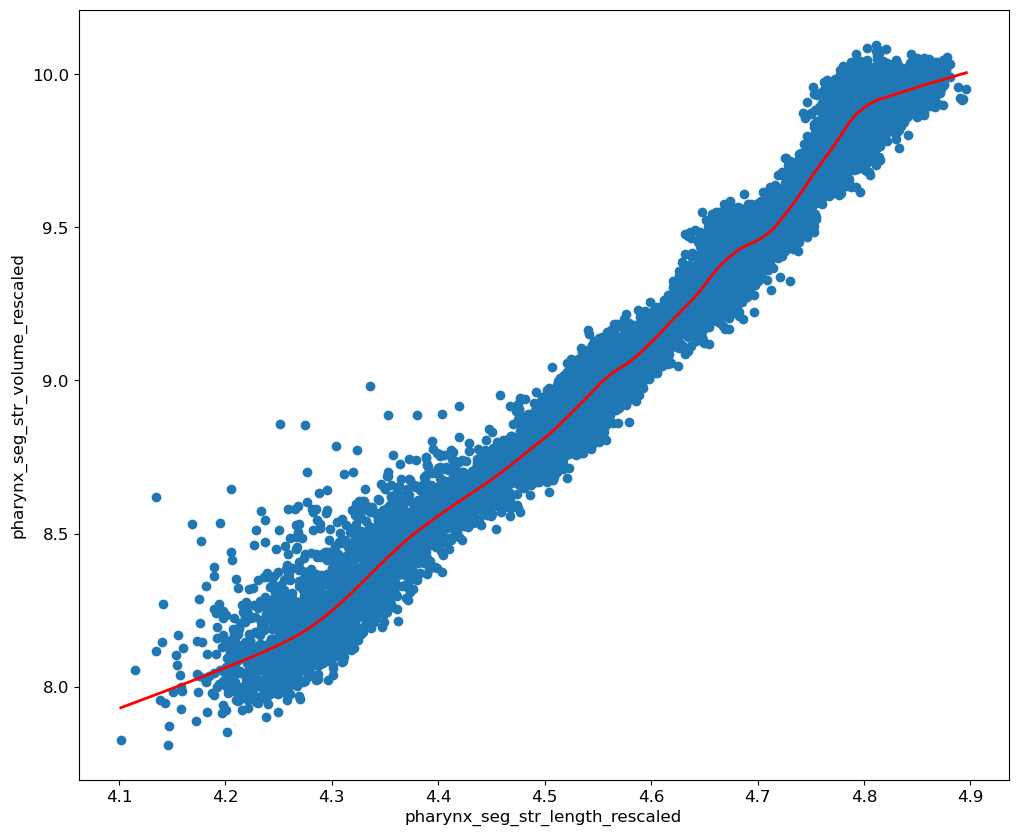

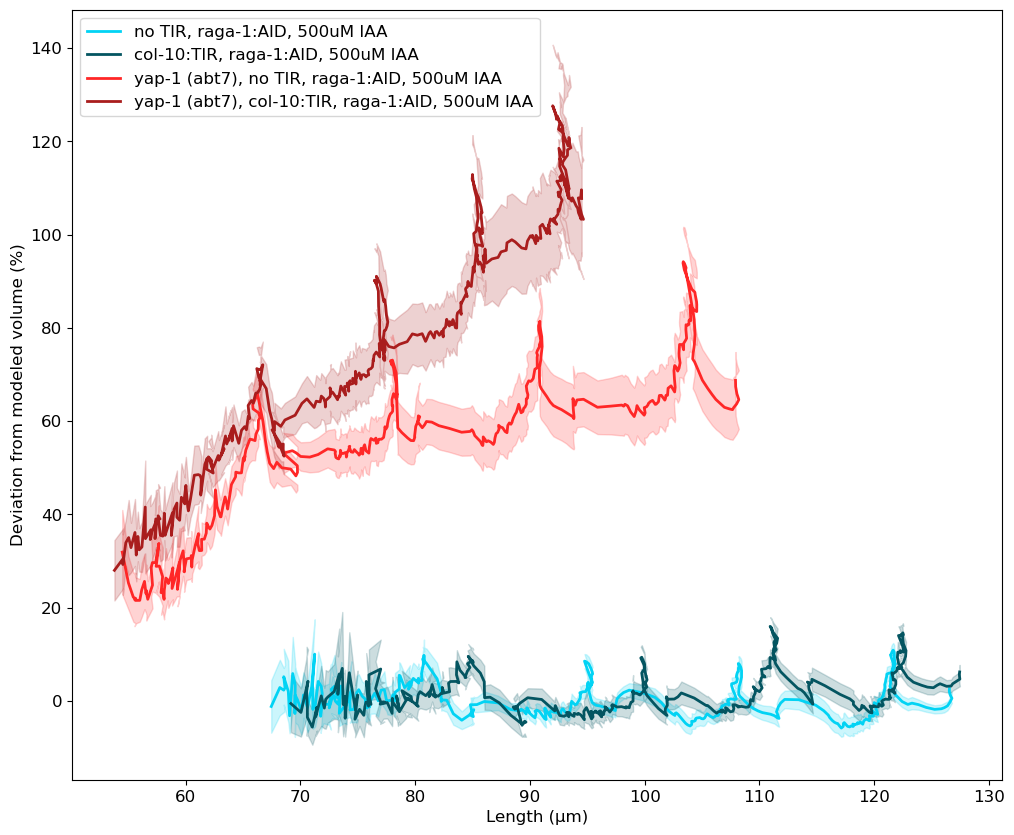

In [21]:
from plotting_functions.proportions import (
    _get_continuous_proportion_model,
    get_deviation_from_model,
)

from plotting_functions.utils_plotting import set_scale, get_colors, build_legend

def plot_continuous_deviation_from_model(
    conditions_struct,
    rescaled_column_one,
    rescaled_column_two,
    control_condition_id,
    conditions_to_plot,
    deviation_as_percentage=True,
    colors=None,
    log_scale=(True, False),
    legend=None,
    x_axis_label=None,
    y_axis_label=None,
    sort_values=True,
):
    color_palette = get_colors(
        conditions_to_plot,
        colors,
    )

    xlbl = rescaled_column_one
    ylbl = rescaled_column_two

    x_axis_label = x_axis_label if x_axis_label is not None else xlbl
    y_axis_label = (
        y_axis_label
        if y_axis_label is not None
        else f"deviation from modeled {rescaled_column_two}"
    )

    control_condition = conditions_struct[control_condition_id]

    control_model = _get_continuous_proportion_model(
        control_condition[rescaled_column_one],
        control_condition[rescaled_column_two],
        x_axis_label=xlbl,
        y_axis_label=ylbl,
        plot_model=True,
    )

    for i, condition_id in enumerate(conditions_to_plot):
        condition = conditions_struct[condition_id]
        rescaled_column_one_values, rescaled_column_two_values = (
            condition[rescaled_column_one],
            condition[rescaled_column_two],
        )
        residuals = get_deviation_from_model(
            rescaled_column_one_values,
            rescaled_column_two_values,
            control_model,
            percentage=deviation_as_percentage,
        )

        if sort_values:
            sorted_indices = np.argsort(rescaled_column_one_values, axis=1)
            rescaled_column_one_values = np.take_along_axis(rescaled_column_one_values, sorted_indices, axis=1)
            residuals = np.take_along_axis(residuals, sorted_indices, axis=1)

        average_column_one_values = np.nanmean(rescaled_column_one_values, axis=0)
        average_residuals = np.nanmean(residuals, axis=0)
        ste_residuals = np.nanstd(residuals, axis=0) / np.sqrt(
            np.sum(~np.isnan(residuals), axis=0)
        )

        label = build_legend(condition, legend)
        plt.plot(
            average_column_one_values,
            average_residuals,
            label=label,
            color=color_palette[i],
        )
        plt.fill_between(
            average_column_one_values,
            average_residuals - 1.96 * ste_residuals,
            average_residuals + 1.96 * ste_residuals,
            color=color_palette[i],
            alpha=0.2,
        )

    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)

    set_scale(plt.gca(), log_scale)

    plt.legend()

    fig = plt.gcf()
    plt.show()

    return fig


fig = plot_continuous_deviation_from_model(
    conditions_struct,
    "pharynx_seg_str_length_rescaled",
    "pharynx_seg_str_volume_rescaled",
    0,
    conditions_to_plot,
    colors=colors,
    log_scale=(False, False),
    legend={"description": ""},
    x_axis_label="Length (µm)",
    y_axis_label="Deviation from modeled volume (%)",
    sort_values=False,
)